# When PCA taken as the dimentionality reduction method in Python

## Environment

First we shall load the necessary libraries in python

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import classification_report,roc_curve, roc_auc_score
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from umap import UMAP
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score


## Data
We shall now load the data and summarise it.

In [78]:
data= pd.read_csv('breast-cancer.csv')
data.drop('id', axis=1, inplace=True)
data['diagnosis'] = data['diagnosis'].astype('category')
data['diagnosis'] = data['diagnosis'].map({'M': 0, 'B': 1})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   diagnosis                569 non-null    category
 1   radius_mean              569 non-null    float64 
 2   texture_mean             569 non-null    float64 
 3   perimeter_mean           569 non-null    float64 
 4   area_mean                569 non-null    float64 
 5   smoothness_mean          569 non-null    float64 
 6   compactness_mean         569 non-null    float64 
 7   concavity_mean           569 non-null    float64 
 8   concave points_mean      569 non-null    float64 
 9   symmetry_mean            569 non-null    float64 
 10  fractal_dimension_mean   569 non-null    float64 
 11  radius_se                569 non-null    float64 
 12  texture_se               569 non-null    float64 
 13  perimeter_se             569 non-null    float64 
 14  area_se   

### Splitting the data to feature and the target variables

In [79]:
# Splitting data into features and target
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

### Splitting the data into training and test data

In [80]:
# Creating a stratified split of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## Preprocessing

The recipe will be as follows:

 * diagnosis is the target
 * up-sample the minority class
 * normalise the numeric predictors
 * experiment with pca dimensional reduction
 

In [81]:
# Define a pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),# Handle class imbalance
    ('normalizer', StandardScaler()),  # Normalize data
    ('pca', PCA()),  # Dimensionality reduction
    ('svm', SVC(kernel='rbf',probability=True))  # SVM classifier
])

In [82]:
# Parameters for GridSearch
param_grid = {
    'pca__n_components': [5,10,15],
    'svm__C': [0.1,0.25,0.50,0.75, 1, 10],
    'svm__gamma': ['scale', 'auto']
}

# Grid search with 10-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=10)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('normalizer', StandardScaler()),
                                       ('pca', PCA()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'pca__n_components': [5, 10, 15],
                         'svm__C': [0.1, 0.25, 0.5, 0.75, 1, 10],
                         'svm__gamma': ['scale', 'auto']},
             scoring='roc_auc')

## Assessment

### What does this mean for unseen data?

In [83]:
# Best model
print("Best parameters: ", grid_search.best_params_)

# Predictions
y_pred = grid_search.predict(X_test)

Best parameters:  {'pca__n_components': 10, 'svm__C': 10, 'svm__gamma': 'scale'}


In [84]:
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

Confusion Matrix:
[[ 63   1]
 [  4 103]]


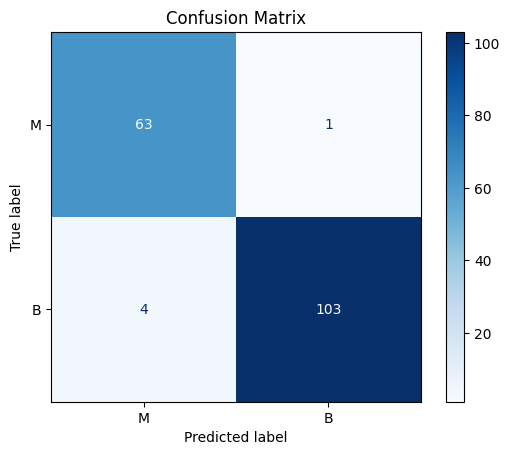

Accuracy: 0.9708
Precision: 0.9904
Recall: 0.9626
F1 Score: 0.9763
Classification Report:
              precision    recall  f1-score   support

           M       0.94      0.98      0.96        64
           B       0.99      0.96      0.98       107

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

ROC AUC: 0.9959


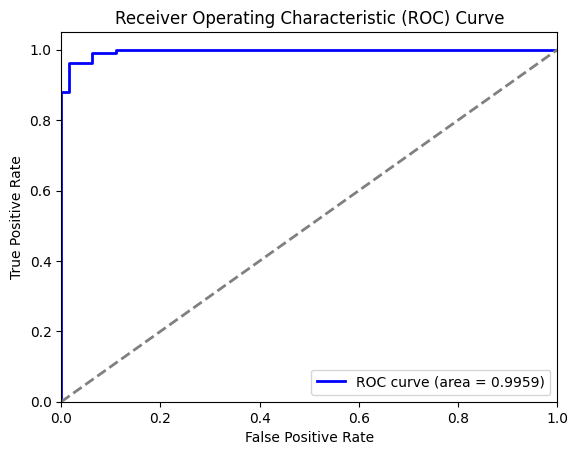

In [85]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualization of the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['M', 'B'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Extract True Positives, False Positives, True Negatives, and False Negatives
TN, FP, FN, TP = cm.ravel()

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

# Generate and print classification report with manually defined target names
report = classification_report(y_test, y_pred, target_names=['M', 'B'])
print("Classification Report:")
print(report)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC: {roc_auc:.4f}')

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


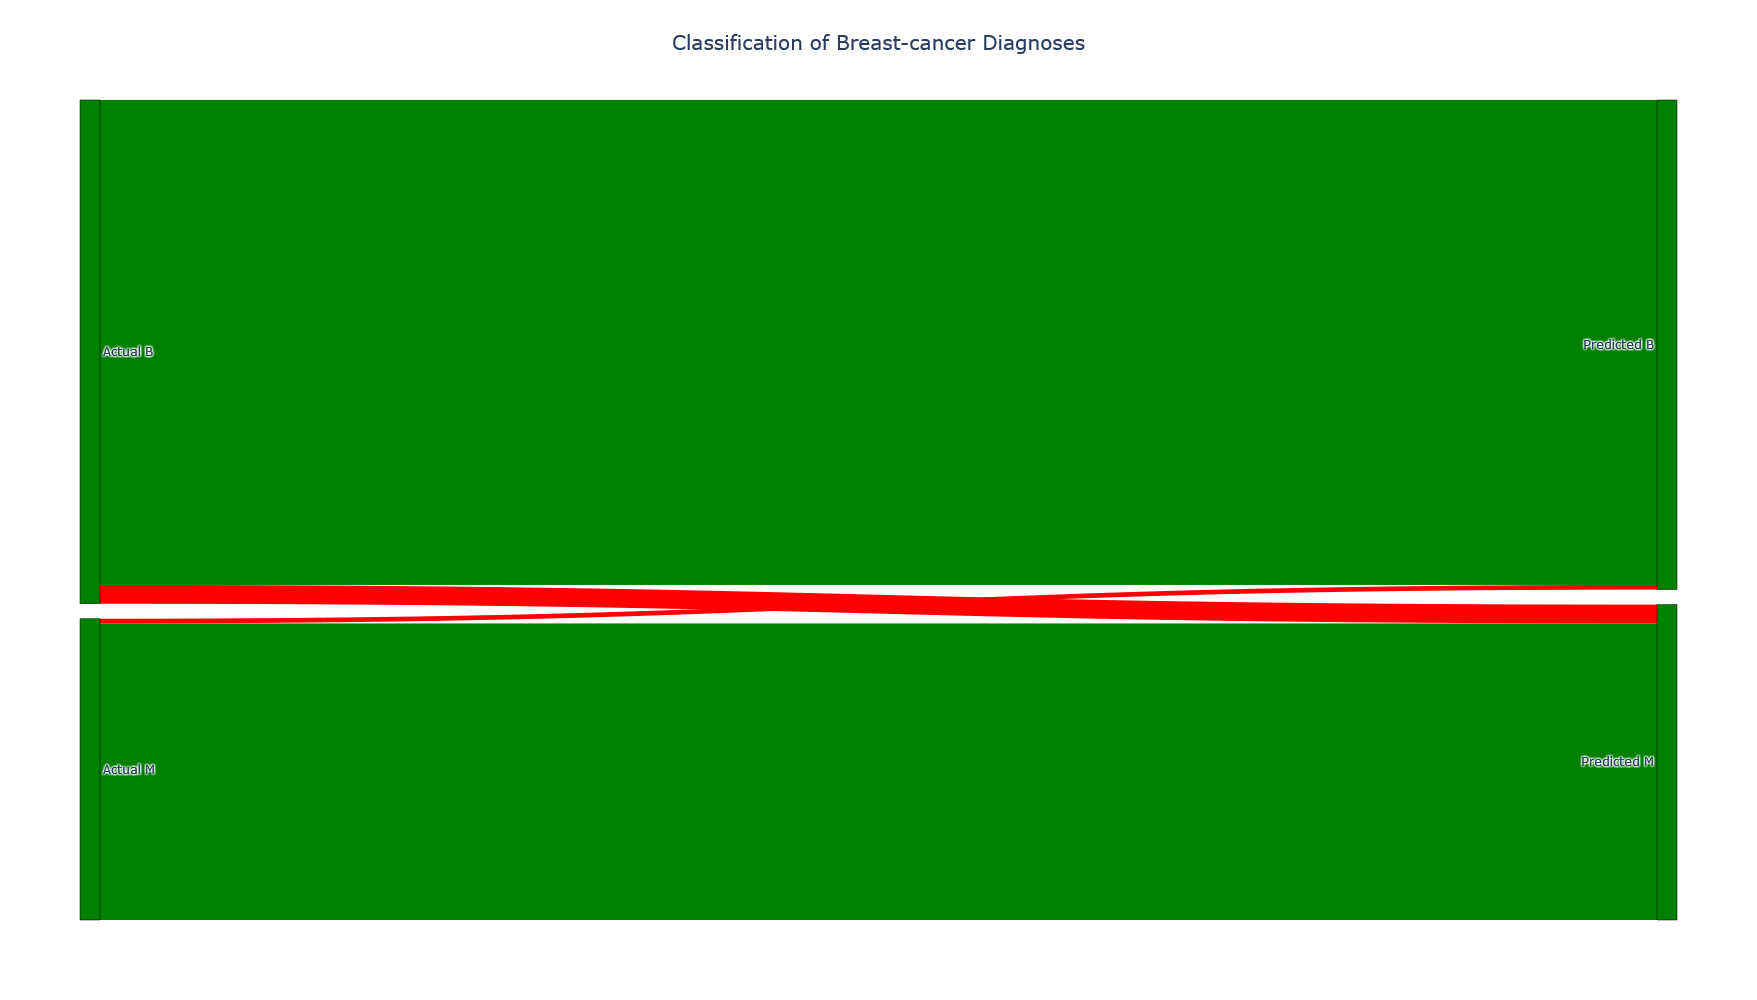

In [87]:


# Assuming y_test and y_pred are already defined
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['B', 'M'], columns=['B', 'M'])

# Create a DataFrame for the alluvial plot
data = cm_df.reset_index().melt(id_vars='index')
data.columns = ['Reference', 'Prediction', 'Freq']
data['Misclassified'] = data['Prediction'] != data['Reference']

# Define the color map for links based on misclassification
color_map = {
    False: 'green',  # Green for correctly classified
    True: 'red'   # Red for misclassified
}

# Construct source, target, value, and color arrays for the Sankey diagram
source = []
target = []
value = []
link_colors = []

# Mapping indices for nodes
index_map = {'B': 1, 'M': 0, 'Predicted B': 3, 'Predicted M': 2}

for i, row in data.iterrows():
    source.append(index_map[row['Reference']])
    target.append(index_map['Predicted ' + row['Prediction']])
    value.append(row['Freq'])
    link_colors.append(color_map[row['Misclassified']])

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=["Actual B", "Actual M", "Predicted B", "Predicted M"],
        color=["green", "green", "green", "green"]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors  # Apply conditional colors
    )
)])

fig.update_layout(
    title_text="Classification of Breast-cancer Diagnoses",
    title_font_size=20,
    title_x=0.5,  
    font_size=12,
    width=600,  
    height=1000   
)

fig.show()
